In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob


import re

plt.rcParams.update({"xtick.direction": "in"})
plt.rcParams.update({"ytick.direction": "in"})
plt.rcParams.update({"xtick.top": True})
plt.rcParams.update({"ytick.right": True})

In [21]:
0.863/100.16*1000*0.5

4.3081070287539935

In [23]:
1.54/210.08*1000*0.5

3.665270373191165

In [15]:
class BiologicData(object):
    def __init__(self, filename):
               
        data_read = []

        with open(filename) as f:
            for line in f.readlines():
                if "Nb header lines" in line:
                    header_lines = int(re.findall("\d+", line)[0])
                data_read.append(line.strip("\n").split("\t"))
                
        header_labels = data_read[header_lines-1]
        self._df = pd.DataFrame(np.array(data_read[header_lines:], dtype=float), columns=header_labels[:-1])
        self.number_cycles = int(self._df["cycle number"].max())
        
        class _Cycle(object):
            def __init__(cycle_self):
                cycle_self_keys = ["capacity", "voltage", "summary_capacity"]
                cycle_self.__dict__.update([(keys, []) for keys in cycle_self_keys])
            
        cycle_types = {"charge": 1,
                       "discharge": 0}
        
        data_types = {"capacity": "Capacity/mA.h",
                      "voltage": "Ecell/V", 
                      }
        
        for cycle_type in cycle_types.keys():
            setattr(self, cycle_type, _Cycle()) 
        
        
        for ncyc in range(self.number_cycles):
            cycle_df = self._df.loc[(self._df["cycle number"]==ncyc) & (abs(self._df["I/mA"])>0)]
            
            for cycle_keys, cycle_values in cycle_types.items():
                cycle_capacity = cycle_df.loc[cycle_df["ox/red"]==cycle_values][data_types["capacity"]]
                vars(self)[cycle_keys].capacity.append(cycle_capacity-cycle_capacity.min())
                
                vars(self)[cycle_keys].voltage.append(cycle_df.loc[cycle_df["ox/red"]==cycle_values][data_types["voltage"]])           
                
                vars(self)[cycle_keys].summary_capacity.append(max(vars(self)[cycle_keys].capacity[-1]))
                
    def save_to_excel(self, save_file_name):
        
        if save_file_name[-5:] != ".xlsx" :
            save_file_name += ".xlsx"
        
        max_cycle_length = max([max([len(data) for data in vars(self)[cycle_keys].capacity]) for cycle_keys in ["discharge", "charge"]])

        data_arrs = dict([(cycle_type, np.full((max_cycle_length, 2*self.number_cycles), np.nan))
                          for cycle_type in ["discharge", "charge"]])

        for cycle_type in ["discharge", "charge"]:
            for ncyc in range(self.number_cycles):
                data_arrs[cycle_type][:len(vars(self)[cycle_type].capacity[ncyc]), 2*ncyc] = vars(self)[cycle_type].capacity[ncyc]
                data_arrs[cycle_type][:len(vars(self)[cycle_type].voltage[ncyc]), 2*ncyc+1] = vars(self)[cycle_type].voltage[ncyc]
                
        column_headers = [item for sublist in [["capacity{}".format(n),
                                                  "voltage{}".format(n)] for n in range(self.number_cycles)] for item in sublist]
        
        discharge_df = pd.DataFrame(data_arrs["discharge"], columns=column_headers)
        charge_df = pd.DataFrame(data_arrs["charge"], columns=column_headers)
        
        summary_capacity_df = pd.DataFrame({"Cycle number": np.arange(self.number_cycles), 
              "Discharge capacity": self.discharge.summary_capacity,
              "Charge capacity": self.charge.summary_capacity})
        
        print("Writing discharge data")
        
        if os.path.isfile(save_file_name):
            with pd.ExcelWriter(save_file_name, engine='openpyxl', mode="a", if_sheet_exists="replace") as writer:
                discharge_df.to_excel(writer,
                                sheet_name="discharge",
                                index=False)
        else:
            with pd.ExcelWriter(save_file_name, engine='openpyxl') as writer:
                discharge_df.to_excel(writer,
                                sheet_name="discharge",
                                index=False)
            
        print("Writing charge data")
        with pd.ExcelWriter(save_file_name, engine='openpyxl', mode="a", if_sheet_exists="replace") as writer:
            charge_df.to_excel(writer,
                                    sheet_name="charge",
                                    index=False)
            
        print("Writing summary capacity data")
        with pd.ExcelWriter(save_file_name, engine='openpyxl', mode="a", if_sheet_exists="replace") as writer:
            summary_capacity_df.to_excel(writer,
                                 sheet_name="summary_capacity",
                                 index=False)
            
    def plot_summary_capacity(self):
        fig, ax = plt.subplots()
        ax.plot(self.discharge.summary_capacity, "o")
        ax.set_ylim([0, None])
        ax.set_xlabel("Cycle number")
        ax.set_ylabel("Capacity (mAh)")
        
        return fig, ax
    
    def plot_capacity_voltage(self, cycle_interval=None):
        if type(cycle_interval) == type(None):
            cycles_to_plot = np.arange(0, self.number_cycles)
        else:
            cycles_to_plot = np.arange(0, self.number_cycles, cycle_interval, dtype=int)
            
        fig, ax = plt.subplots()

        for cyc in cycles_to_plot:    
            d, = ax.plot(self.discharge.capacity[cyc],
                    self.discharge.voltage[cyc], label=cyc)
            c = ax.plot(self.charge.capacity[cyc],
                    self.charge.voltage[cyc], color=d.get_color())

        ax.legend(title="Cycle number", loc="center left", bbox_to_anchor=(1, 0.5))
        ax.set_ylabel("Voltage vs. Li/ Li$^{+}$ (V)")
        ax.set_xlabel("Capacity (mAh)")
        ax.set_xlim([0, None])
        plt.tight_layout()
        
        return fig, ax
            
    

In [16]:
filename = os.path.join("20250721-BYP-KB-A-G2-0-5.8mg-0.1C-200cycles_CD1-continue_CD1", 
                       "20250721-BYP-KB-A-G2-0-5.8mg-0.1C-200cycles_CD1-continue_CD1.mpt")
self = BiologicData(filename)

In [7]:
self.save_to_excel("new_test_file_v2")

Writing discharge data
Writing charge data
Writing summary capacity data


<IPython.core.display.Javascript object>


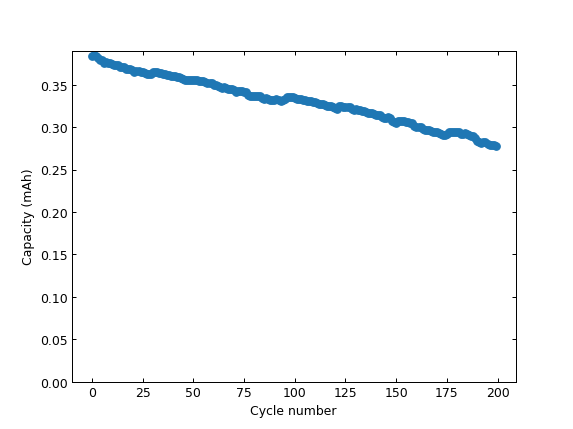

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Cycle number', ylabel='Capacity (mAh)'>)

In [17]:
self.plot_summary_capacity()

<IPython.core.display.Javascript object>


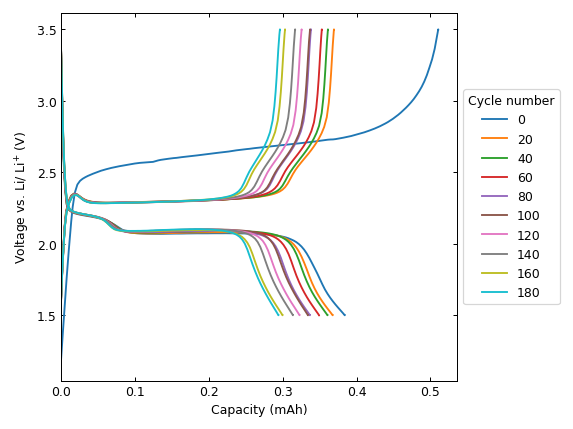

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Capacity (mAh)', ylabel='Voltage vs. Li/ Li$^{+}$ (V)'>)

In [18]:
self.plot_capacity_voltage(cycle_interval=20)

In [ ]:
fig, ax = plt.subplots()

cycle_interval = 20
cycles_to_plot = np.arange(0, self.number_cycles, cycle_interval, dtype=int)

for cyc in cycles_to_plot:    
    d, = ax.plot(self.discharge.capacity[cyc],
            self.discharge.voltage[cyc], label=cyc)
    c = ax.plot(self.charge.capacity[cyc],
            self.charge.voltage[cyc], color=d.get_color())
    
ax.legend(title="Cycle number")
ax.set_ylabel("Voltage vs. Li/ Li$^{+}$ (V)")
ax.set_xlabel("Capacity (mAh)")
ax.set_xlim([0, None])

In [ ]:
cycles_to_plot